# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
all_time =3000
Time = 100
neuron_num = 85
datax = scipy.io.loadmat("spike85_k09_6000.mat")
y_data = datax["spike85_k09_6000"][:,:all_time].T
traj = scipy.io.loadmat("trj85_k09_6000.mat")
traj = traj["trj85_k09_6000"][:,:all_time].T
NRep=int(all_time/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
y = x.detach().clone()

(3000, 85)
torch.Size([30, 100, 85])


## View example Ground Truth Firing Rates

(100, 85)


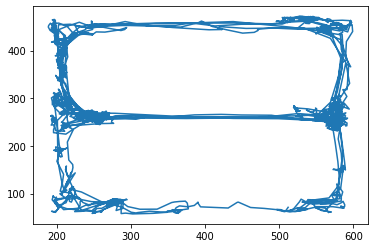

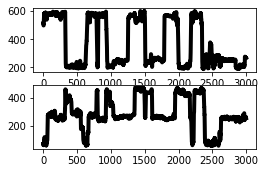

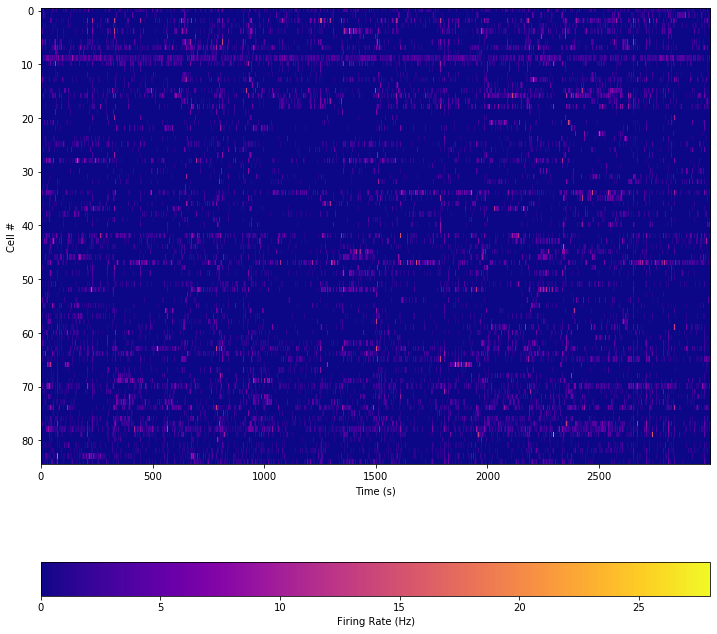

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [5]:
hyperparams = load_parameters('./parameters.yaml')
save_parameters(hyperparams)
hyperparams

{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 200,
 'u_dim': 1,
 'factors_dim': 2,
 'g0_encoder_dim': 200,
 'c_encoder_dim': 128,
 'controller_dim': 128,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [6]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 2007


#### Pick up where you left off (if you have a recent save) 

In [7]:
# model.load_checkpoint('recent')

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

In [8]:
model.fit(train_ds, valid_ds, max_epochs=1, batch_size=3, use_tensorboard=True,
          train_truth=train_ds, valid_truth=valid_ds)

Beginning training...
Epoch:    1, Step:    10, training loss: 21634.732, validation loss: 24002.752
...training complete.


## Load checkpoint with lowest validation error 

In [9]:
model.load_checkpoint('best')

## Plot results summary 

In [13]:
print(output.shape)
model.plot_summary(data=output, truth=output)

(30, 100, 85)


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'